# Unveiling Character Dynamics: A Quantitative Exploration of Movie Narratives

Welcome to our project notebook for Milestone P2! 

Throughout this phase, our team has dedicated efforts to enhance our project proposal and initiate initial examinations, laying the groundwork for an effective expedition into data exploration and analysis.

## Table of Contents
- [1. Exploratory Data Analysis✅](#1-exploratory-data-analysis)
    - [1.1 Movie metadata](#11-movie-metadata)
    - [1.2 Character metadata](#12-character-metadata)
- [2. Generation of Character Networks🏗️](#2-generation-of-character-networks)
- [3. Persona Extraction and Mapping🚧](#3-persona-extraction-and-mapping)
- [4. Main and Side Character Analysis🚧](#4-main-and-side-character-analysis)
- [5. Network Dynamics Analysis🚧](#5-network-dynamics-analysis)

In [32]:
import ast
import re
import spacy
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from helper import *

%matplotlib inline
plt.rcParams['font.family'] = 'Times New Roman'

## 1. Exploratory Data Analysis
### 1.1 Movie metadata
[Back to table of contents](#table-of-contents)

The movie metadata set includes movie box office revenue, genre, release date, runtime, and language. We did some exploratory analysis to better understand the movie distribution, providing us the neccessary context of those movies.

In [33]:
# Load Data
movies = pd.read_csv('./data/movie.metadata.tsv', sep='\t', header=None)
movies.columns = [
    'wikipedia_movie_id',
    'freebase_movie_id',
    'movie_name',
    'movie_release_date',
    'movie_box_office_revenue',
    'movie_runtime',
    'movie_languages',
    'movie_countries',
    'movie_genres'
]
movies.head(3)

,wikipedia_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."


In [34]:
# Print summary information
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81741 entries, 0 to 81740
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   wikipedia_movie_id        81741 non-null  int64  
 1   freebase_movie_id         81741 non-null  object 
 2   movie_name                81741 non-null  object 
 3   movie_release_date        74839 non-null  object 
 4   movie_box_office_revenue  8401 non-null   float64
 5   movie_runtime             61291 non-null  float64
 6   movie_languages           81741 non-null  object 
 7   movie_countries           81741 non-null  object 
 8   movie_genres              81741 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 5.6+ MB


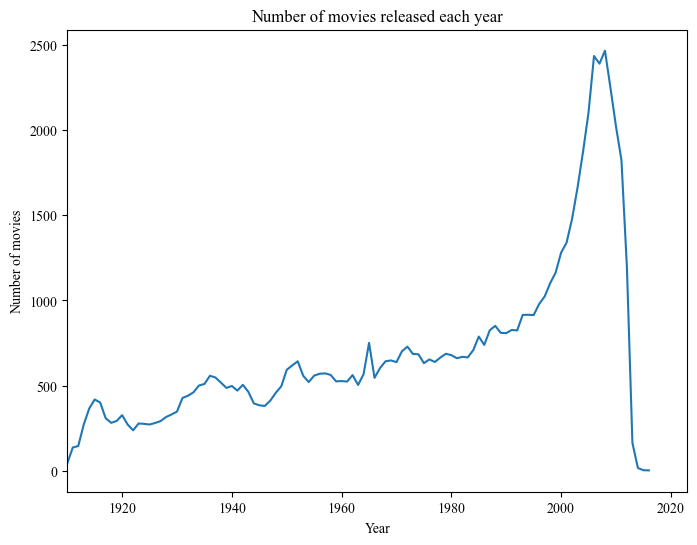

In [35]:
# find the year of the movie
movies['year'] = movies['movie_release_date'].str.extract('(\d{4})', expand=False)
movies['year'] = pd.to_numeric(movies['year'], downcast='integer')

# plot the number of movies released each year
movies_per_year = movies.groupby('year')['movie_name'].count()

plt.figure(figsize=(8, 6))
plt.title('Number of movies released each year')
plt.ylabel('Number of movies')
plt.xlabel('Year')
plt.xlim(1910, 2023)
plt.plot(movies_per_year)
plt.show()

We first look at the movie release year because movies in different time periods may have different narrative structure and character dynamics. We know that the very first "movie" was produced in 1878 [[1]](https://historycooperative.org/first-movie-ever-made/), so we choose the time range from 1878 to 2023. As we can see, our dataset consists movies from the very early age to the modern times, which provides a solid foundation for us to study and compare the character dynamics over time.

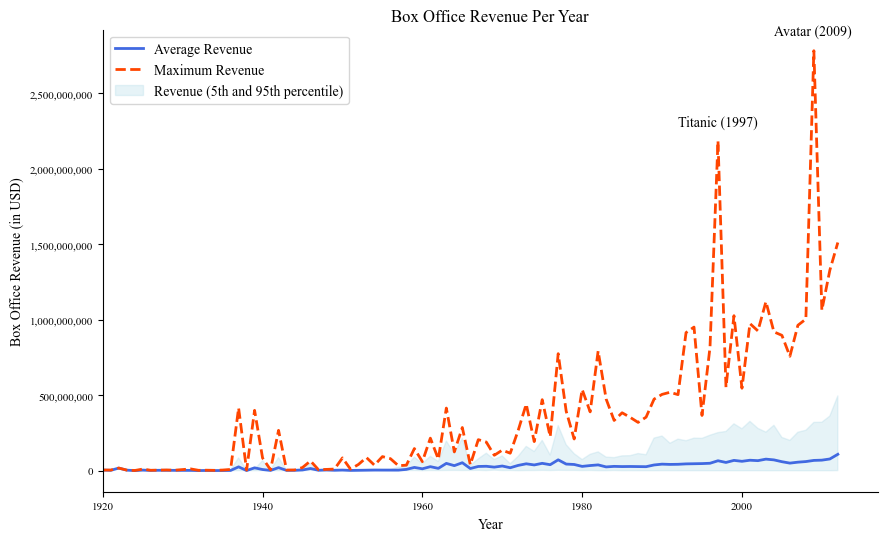

In [36]:
# average box office revenue per year
movies['movie_box_office_revenue'] = pd.to_numeric(movies['movie_box_office_revenue'], errors='coerce')
mean_revenue_per_year = movies.groupby('year')['movie_box_office_revenue'].mean()
max_revenue_per_year = movies.groupby('year')['movie_box_office_revenue'].max()
revenue_per_year_25 = movies.groupby('year')['movie_box_office_revenue'].quantile(0.05)
revenue_per_year_75 = movies.groupby('year')['movie_box_office_revenue'].quantile(0.95)

# find the name of the two movies with the highest revenue
top1_movie_idx = movies[movies['movie_box_office_revenue'] == max_revenue_per_year.max()].index[0]
top2_movie_idx = movies[movies['movie_box_office_revenue'] == max_revenue_per_year.sort_values(ascending=False).iloc[1]].index[0]


plt.figure(figsize=(10, 6))
plt.title('Box Office Revenue Per Year', fontsize=12)
plt.ylabel('Box Office Revenue (in USD)', fontsize=10)
plt.xlabel('Year', fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlim(1920, 2017)

plt.plot(mean_revenue_per_year, color='royalblue', linestyle='-', linewidth=2, label='Average Revenue')
plt.plot(max_revenue_per_year, color='orangered', linestyle='--', linewidth=2, label='Maximum Revenue')

# Shaded area for 5th and 95th percentile
plt.fill_between(mean_revenue_per_year.index, 
                revenue_per_year_25,
                revenue_per_year_75, 
                color='lightblue', alpha=0.3,
                label='Revenue (5th and 95th percentile)')

# Annotate the two movies with the highest revenue
plt.annotate(movies['movie_name'][top1_movie_idx]+' ('+str(int(movies['year'][top1_movie_idx]))+')',
            xy=(movies['year'][top1_movie_idx], movies['movie_box_office_revenue'][top1_movie_idx]),
            xytext=(movies['year'][top1_movie_idx]-5, movies['movie_box_office_revenue'][top1_movie_idx]+1e8),
            fontsize=10)
plt.annotate(movies['movie_name'][top2_movie_idx]+' ('+str(int(movies['year'][top2_movie_idx]))+')',
            xy=(movies['year'][top2_movie_idx], movies['movie_box_office_revenue'][top2_movie_idx]),
            xytext=(movies['year'][top2_movie_idx]-5, movies['movie_box_office_revenue'][top2_movie_idx]+1e8),
            fontsize=10)

# Format y-axis as currency
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.gca().xaxis.grid(False)  # Disable the vertical grid lines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# plt.gca().spines['left'].set_visible(False)

plt.legend(loc='upper left', fontsize=10)

plt.show()


We will mainly focus on the character dynamics of the plot itself. However, we are still curious about what makes a good story. From this figure, we can see that the average revenue is rather stable across the time (taking inflation into account). But the most successful movies earn significantly more than others. Avatar and Titanic are two most successful movies in history.

We could possibly compare the character dynamics of the most successful movies and the least successful movies to see the difference.

There is an outlier which doesn't show in this plot:  Zero Tolerance ( 1995 ), which has a runtime of  1079281.0 minutes !


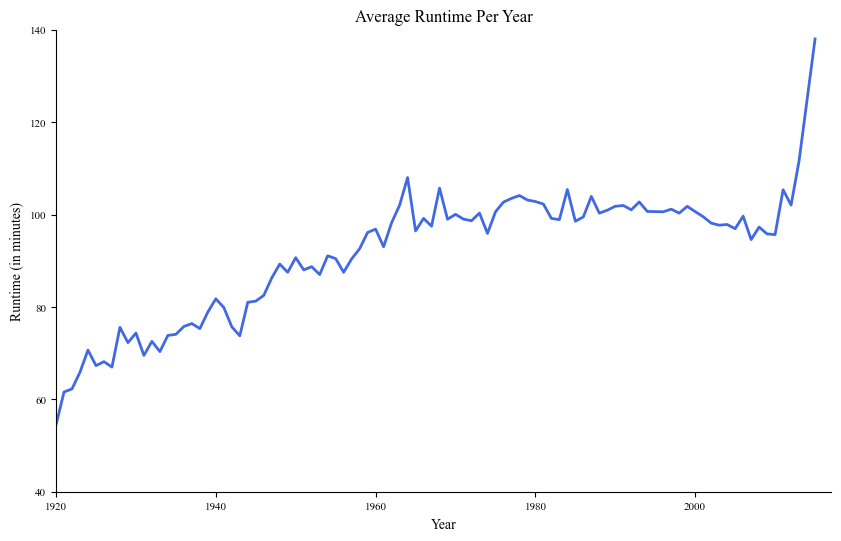

In [37]:
# average runtime per year
movies['movie_runtime'] = pd.to_numeric(movies['movie_runtime'], errors='coerce')
mean_runtime_per_year = movies.groupby('year')['movie_runtime'].mean()
# drop the outlier
max_mean_runtime_per_year = mean_runtime_per_year.sort_values(ascending=False).iloc[1]
mean_runtime_per_year = mean_runtime_per_year[mean_runtime_per_year < max_mean_runtime_per_year]

outlier_idx = movies[movies['movie_runtime'] == movies['movie_runtime'].max()].index[0]
print('There is an outlier which doesn\'t show in this plot: ',
        movies['movie_name'][outlier_idx], '(',
        str(int(movies['year'][outlier_idx])),
        '), which has a runtime of ',
        movies['movie_runtime'][outlier_idx], 'minutes !')

plt.figure(figsize=(10, 6))
plt.title('Average Runtime Per Year', fontsize=12)
plt.ylabel('Runtime (in minutes)', fontsize=10)
plt.xlabel('Year', fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlim(1920, 2017)
plt.ylim(40, 140)

plt.plot(mean_runtime_per_year, color='royalblue', linestyle='-', linewidth=2, label='Average Runtime')

plt.gca().xaxis.grid(False)  # Disable the vertical grid lines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()

The movies in early times are usually shorter than nowadays, probably because of the techinical limitations. On the one hand, this could bring differences in movie storytelling. On the other hand, this reminds us that we should be more careful about the network attributes (degrees, density, etc.) when we do further analysis.

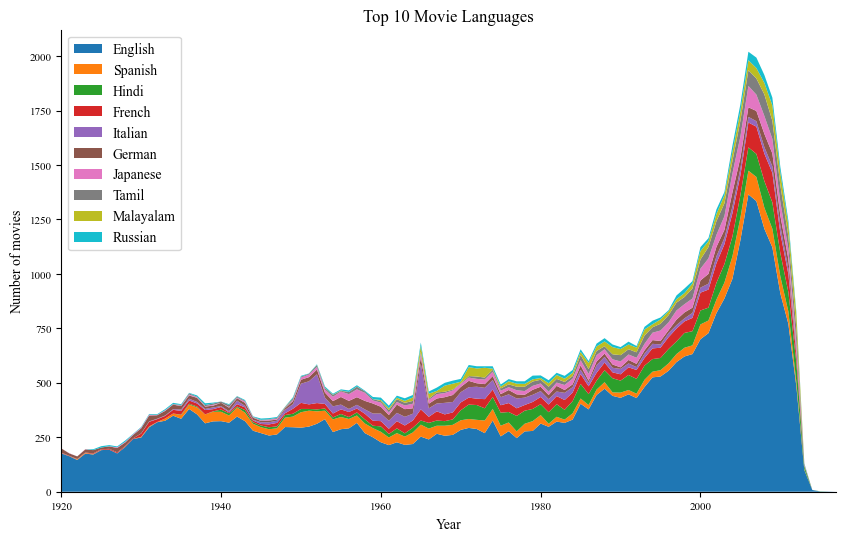

In [38]:
# movie language distribution
query = re.compile(r'"(\w+) Language"')
movies['movie_languages_cleaned'] = movies['movie_languages'].fillna('[]')
movies['movie_languages_cleaned'] = movies['movie_languages'].apply(lambda x: query.findall(x))

movies['movie_languages_num'] = movies['movie_languages_cleaned'].apply(lambda x: len(x) if x != [] else 1)
movie_languages_per_year = {}

for year in range(1920, 2018):
    languages = movies[movies['year'] == year]['movie_languages_cleaned'].sum()
    languages_count = pd.Series(languages).value_counts()
    movie_languages_per_year[year] = languages_count

movie_languages_per_year = pd.DataFrame(movie_languages_per_year).fillna(0).astype(int).transpose()

# plot the top 10 languages
top10_languages = movie_languages_per_year.sum().sort_values(ascending=False).index[:10]
movie_languages_per_year = movie_languages_per_year[top10_languages]

plt.figure(figsize=(10, 6))
plt.title('Top 10 Movie Languages', fontsize=12)
plt.ylabel('Number of movies', fontsize=10)
plt.xlabel('Year', fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlim(1920, 2017)

plt.stackplot(movie_languages_per_year.index,
                movie_languages_per_year.values.T,
                labels=movie_languages_per_year.columns)

plt.gca().xaxis.grid(False)  # Disable the vertical grid lines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.legend(loc='upper left', fontsize=10)

plt.show()

Most of the movies are in English. And from the interactive figure below, we can see that a large proportion of movies are produced in America. This adds difficulty for us if we want to analyze the culture differences in character dynamics framing. We need to consider this seriously and make sure the data is reasonably enough for further analysis.

In [39]:
# country distribution
query = re.compile(r': "(.+)"')
movies['movie_countries_cleaned'] = movies['movie_countries'].fillna('[]')
movies['movie_countries_cleaned'] = movies['movie_countries'].apply(lambda x: query.findall(x)[0] if query.findall(x) != [] else '')

# plot the country distribution per year
country_distribution = movies.groupby(['year', 'movie_countries_cleaned']).size().reset_index(name='count')
country_distribution = country_distribution[country_distribution['year'] >= 1920]
country_distribution['year'] = country_distribution['year'].astype(int)

fig = px.choropleth(
    country_distribution, 
    locations="movie_countries_cleaned", 
    locationmode='country names',
    color="count", 
    hover_name="movie_countries_cleaned",
    animation_frame="year",
    range_color=[0, country_distribution['count'].max()],
    title="Movie Production by Country Over Time"
)

fig.update_layout(
    geo=dict(
        showframe=False,
        showcoastlines=False,
    ),
    width=1000,  # Adjust the width
    height=600   # Adjust the height
)

fig.show()

This interactive image cannot be viewed directly from github.

To see it, first make sure that plotly is installed (pip install plotly) in your local environment, then run the file.

![Map](./generated/images/country_distribution_per_year.png)

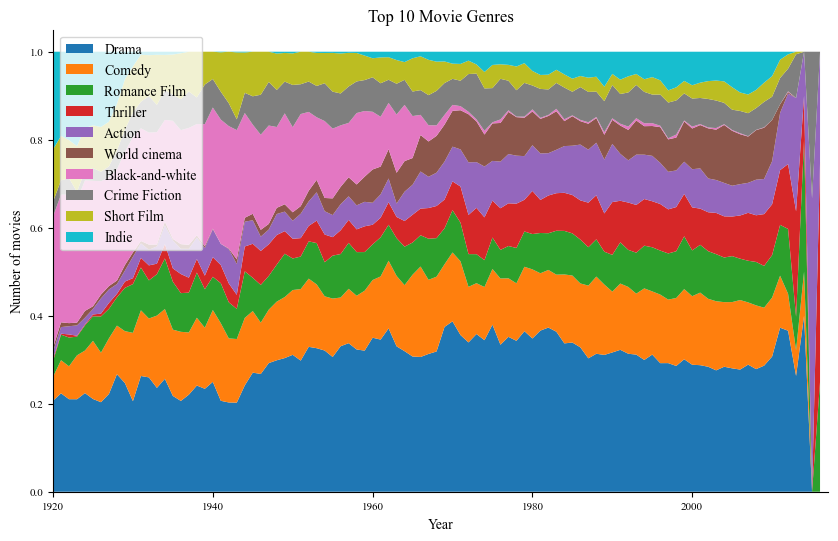

In [40]:
# genre distribution
query = re.compile(r': "(.+?)"')
movies['movie_genres_cleaned'] = movies['movie_genres'].fillna('[]')
movies['movie_genres_cleaned'] = movies['movie_genres'].apply(lambda x: query.findall(x))

movie_genres_per_year = {}
for year in range(1920, 2018):
    genres = movies[movies['year'] == year]['movie_genres_cleaned'].sum()
    genres_count = pd.Series(genres).value_counts()
    movie_genres_per_year[year] = genres_count

movie_genres_per_year = pd.DataFrame(movie_genres_per_year).fillna(0).astype(int).transpose()

# plot the top 10 genres
top10_genres = movie_genres_per_year.sum().sort_values(ascending=False).index[:10]
movie_genres_per_year = movie_genres_per_year[top10_genres]

# change to proportion
movie_genres_per_year = movie_genres_per_year.div(movie_genres_per_year.sum(axis=1), axis=0)

plt.figure(figsize=(10, 6))
plt.title('Top 10 Movie Genres', fontsize=12)
plt.ylabel('Number of movies', fontsize=10)
plt.xlabel('Year', fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlim(1920, 2017)

plt.stackplot(movie_genres_per_year.index,
                movie_genres_per_year.values.T,
                labels=movie_genres_per_year.columns)

plt.gca().xaxis.grid(False)  # Disable the vertical grid lines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.legend(loc='upper left', fontsize=10)

plt.show()



We plot the distribution of the top 10 genres across time (Still needs improvement, cause there are genres having different names but expressing the same topic). We can see the increases and decreases across time. But our goal is to analyze the changes of character network dynamics of different genres, which can provide us a deeper understanding of the movies.

### 1.2 Character metadata
[Back to table of contents](#table-of-contents)

Character Metadata encompasses character names and associated details regarding the actors portraying them, such as gender and estimated age during the movie's release.

In [41]:
characters_df= pd.read_csv('./data/character.metadata.tsv', sep='\t', header=None)
characters_df.columns = [
    'wikipedia_movie_id',
    'freebase_movie_id',
    'movie_release_date',
    'character_name',
    'actor_dob',
    'actor_gender',
    'actor_height',
    'actor_ethnicity',
    'actor_name',
    'actor_age',
    'freebase_character_map_1',
    'freebase_character_map_2',
    'freebase_character_map_3'
]
characters_df.head()

,wikipedia_movie_id,freebase_movie_id,movie_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,freebase_character_map_1,freebase_character_map_2,freebase_character_map_3
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [42]:
characters_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450669 entries, 0 to 450668
Data columns (total 13 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   wikipedia_movie_id        450669 non-null  int64  
 1   freebase_movie_id         450669 non-null  object 
 2   movie_release_date        440674 non-null  object 
 3   character_name            192794 non-null  object 
 4   actor_dob                 344524 non-null  object 
 5   actor_gender              405060 non-null  object 
 6   actor_height              154824 non-null  float64
 7   actor_ethnicity           106058 non-null  object 
 8   actor_name                449441 non-null  object 
 9   actor_age                 292556 non-null  float64
 10  freebase_character_map_1  450669 non-null  object 
 11  freebase_character_map_2  192804 non-null  object 
 12  freebase_character_map_3  449854 non-null  object 
dtypes: float64(2), int64(1), object(10)
memory u

First, we'll have a look at the missing data here.

In [43]:
# Calculate missing data ratio for each column
missing_ratio = characters_df.isnull().mean()

# Display the missing data ratio for each column
print("Missing Data Ratio for Each Column:")
print(missing_ratio)


Missing Data Ratio for Each Column:
wikipedia_movie_id          0.000000
freebase_movie_id           0.000000
movie_release_date          0.022178
character_name              0.572205
actor_dob                   0.235528
actor_gender                0.101203
actor_height                0.656457
actor_ethnicity             0.764665
actor_name                  0.002725
actor_age                   0.350841
freebase_character_map_1    0.000000
freebase_character_map_2    0.572183
freebase_character_map_3    0.001808
dtype: float64


As we can see from above, several columns have missing data. Notable columns with high missing data ratios include actor_ethnicity (76.47%), character_name (57.22%), actor_height (65.65%), and actor_age (35.08%).Meanwhile, the missing data ratios for some columns are relatively low, such as wikipedia_movie_id, freebase_movie_id, and freebase_character_map_1, which have no missing data.

Then, we shall examine the distribution of estimated character ages (inferred from actors' age in the year when the movie was released with few exceptions) across gender.

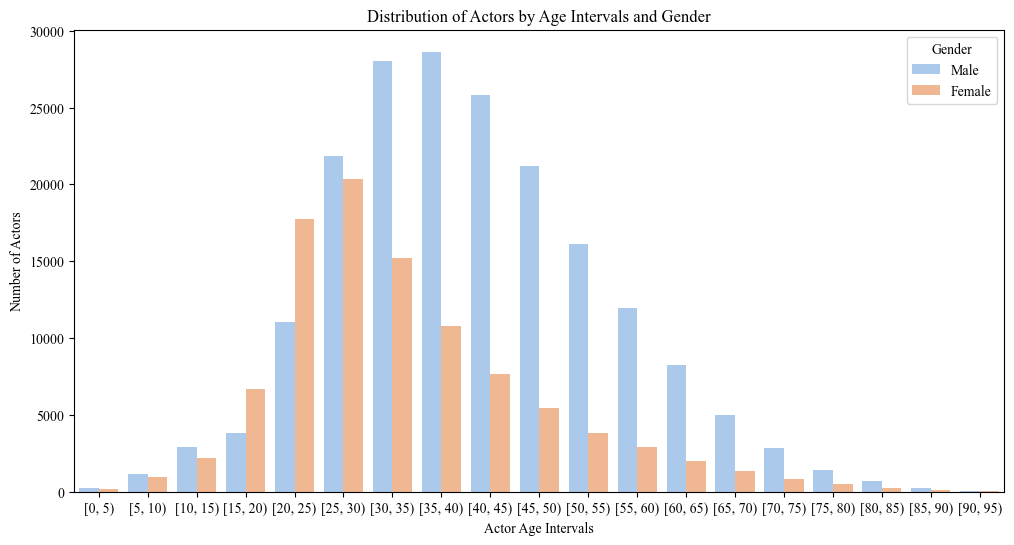

In [44]:
# Drop rows with missing values in 'actor_age' and 'actor_gender' for better visualization
data_for_plot = characters_df.dropna(subset=['actor_age', 'actor_gender'])

# Create age intervals
age_intervals = pd.cut(data_for_plot['actor_age'], bins=range(0, 100, 5), right=False)

# Set up the figure and axes
plt.figure(figsize=(12, 6))

# Create a countplot for each gender with age intervals of 3
sns.countplot(x=age_intervals, hue='actor_gender', data=data_for_plot, palette='pastel', hue_order=['M', 'F'])

# Set labels and title
plt.title('Distribution of Actors by Age Intervals and Gender')
plt.xlabel('Actor Age Intervals')
plt.ylabel('Number of Actors')

# Display the legend
plt.legend(title='Gender', labels=['Male', 'Female'])

# Show the plot
plt.show()


As shown from the graph, for characters (actors) whose age is less than 30, there's no significantly more males than females (relatively more females than males in age interval from 15 to 25); but after 30 it's obvious that there are much more males than females.And overall, it still holds true that there are more male characters/actors than female ones. For our further analysis about gender dynamics, this column would remain very useful to us.

Then we'll look at the height of characters/actors.

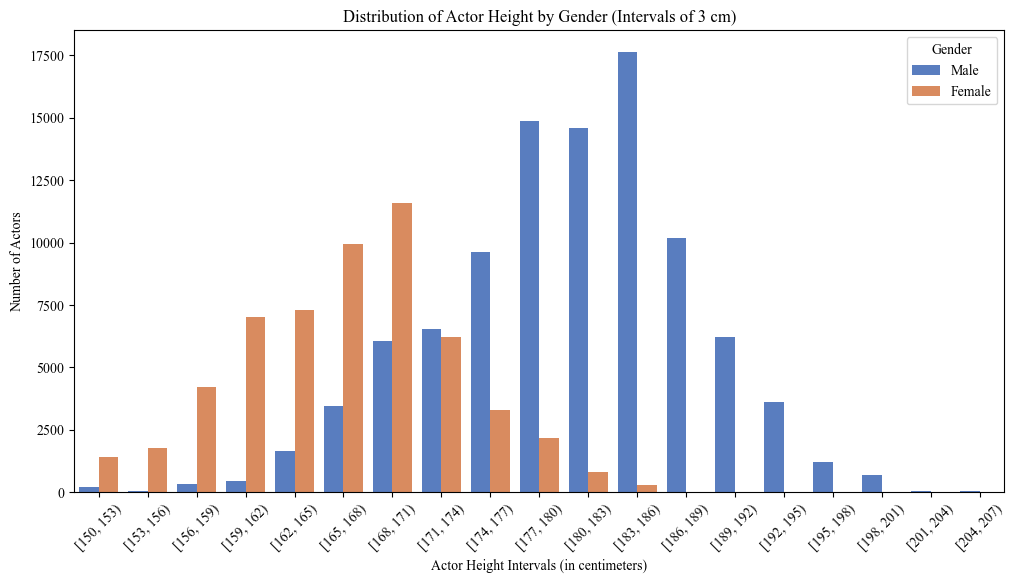

In [45]:
# Drop rows with missing values in 'actor_height' and 'actor_gender'
data_for_height_plot = characters_df.dropna(subset=['actor_height', 'actor_gender']).copy() 

# Convert height to centimeters and create height intervals in centimeters
data_for_height_plot.loc[:, 'actor_height_cm'] = data_for_height_plot['actor_height'] * 100

# Create height intervals in centimeters
data_for_height_plot.loc[:, 'height_intervals'] = pd.cut(data_for_height_plot['actor_height_cm'], bins=range(150, 210, 3), right=False)

# Set up the figure and axes
plt.figure(figsize=(12, 6))

# Create a countplot for height intervals with gender as hues
sns.countplot(x='height_intervals', hue='actor_gender', data=data_for_height_plot, palette='muted', hue_order=['M', 'F'], dodge=True)

# Set labels and title
plt.title('Distribution of Actor Height by Gender (Intervals of 3 cm)')
plt.xlabel('Actor Height Intervals (in centimeters)')
plt.ylabel('Number of Actors')
plt.xticks(rotation=45)

# Display the legend with specified labels
plt.legend(title='Gender', labels=['Male', 'Female'])

# Show the plot
plt.show()


As we can see, generally speaking, the height of both male and female actors respectively follows the normal distribution with different mean values, which is consistent with common biological difference.

Ethnicity is also an important factor about the actors and characters, though it's not always the same for both. Despite the three-quarters missing data in this column, we try to calculate and list the top 9 ethnicities here.

In [46]:
# Drop rows with missing values in 'actor_ethnicity' and 'actor_gender'
data_for_ethnicity_plot = characters_df.dropna(subset=['actor_ethnicity', 'actor_gender'])

# Calculate the percentage distribution of each ethnicity
ethnicity_percentage = data_for_ethnicity_plot['actor_ethnicity'].value_counts(normalize=True) * 100

# Select the top 9 ethnicities
top_9_ethnicities = ethnicity_percentage.head(9)
top_9_ethnicities_series = pd.Series(top_9_ethnicities.values, index=top_9_ethnicities.index, name='Ethnicity Distribution')

# Apply convert_freebase_id_to_entity function to the index of top_10_ethnicities_series
converted_ethnicities = top_9_ethnicities_series.index.map(convert_freebase_id_to_entity)

# Create a new DataFrame with the converted ethnicities and their distribution percentages
top_9_actor_ethnicity = pd.DataFrame({'actor_ethnicity': converted_ethnicities, 'percentage_distribution': top_9_ethnicities_series})

# Display the new DataFrame
print(top_9_actor_ethnicity)

                    actor_ethnicity  percentage_distribution
actor_ethnicity                                             
/m/0dryh9k            Indian_people                15.423871
/m/0x67           African_Americans                 9.573535
/m/041rx                       Jews                 9.547122
/m/02w7gg            English_people                 5.815434
/m/033tf_           Irish_Americans                 3.638302
/m/0xnvg          Italian_Americans                 2.788390
/m/02ctzb              White_people                 2.175246
/m/07hwkr           White_Americans                 2.122421
/m/07bch9        Scottish_Americans                 2.096952


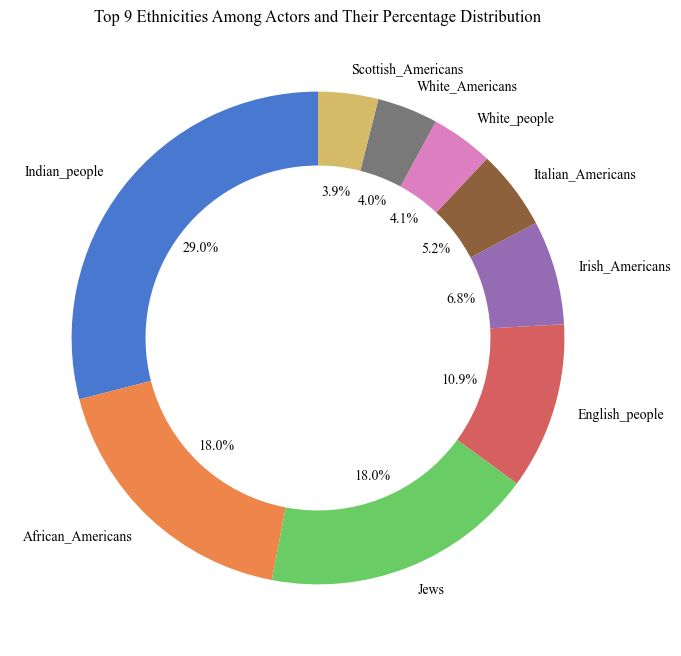

In [47]:
# Set up the figure and axes
plt.figure(figsize=(8, 8))

# Create a pie chart for the top 10 ethnicities
plt.pie(top_9_actor_ethnicity['percentage_distribution'], labels=top_9_actor_ethnicity['actor_ethnicity'],
        autopct='%1.1f%%', startangle=90, colors=sns.color_palette('muted'), wedgeprops=dict(width=0.3))

# Set labels and title
plt.title('Top 9 Ethnicities Among Actors and Their Percentage Distribution')

# Show the plot
plt.show()


The top three ethnicities are Indian People, African Americans, and Jews, each contributing significantly to the overall distribution.

## 2. Generation of Character Networks
[Back to table of contents](#table-of-contents)

In this Section we will demonstrate the data processing pipeline by going through the process for one movie plot (the Hunger Games), and displaying our results.

Keep in mind some of these function are incomplete and are still subject to improvement, but we feel the results are promising enough to display in order the justify the feasibility of our project.

### Step 1: preprocessing and exploratory analysis

In [48]:
from spacy import displacy

nlp = spacy.load("en_core_web_sm")

plot='''
The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl  between the ages of 12 and 18 selected by lottery  for the annual Hunger Games. The tributes must fight to the death in an arena; the sole survivor is rewarded with fame and wealth. In her first Reaping, 12-year-old Primrose Everdeen is chosen from District 12. Her older sister Katniss volunteers to take her place. Peeta Mellark, a baker's son who once gave Katniss bread when she was starving, is the other District 12 tribute. Katniss and Peeta are taken to the Capitol, accompanied by their frequently drunk mentor, past victor Haymitch Abernathy. He warns them about the "Career" tributes who train intensively at special academies and almost always win. During a TV interview with Caesar Flickerman, Peeta unexpectedly reveals his love for Katniss. She is outraged, believing it to be a ploy to gain audience support, as "sponsors" may provide in-Games gifts of food, medicine, and tools. However, she discovers Peeta meant what he said. The televised Games begin with half of the tributes killed in the first few minutes; Katniss barely survives ignoring Haymitch's advice to run away from the melee over the tempting supplies and weapons strewn in front of a structure called the Cornucopia. Peeta forms an uneasy alliance with the four Careers. They later find Katniss and corner her up a tree. Rue, hiding in a nearby tree, draws her attention to a poisonous tracker jacker nest hanging from a branch. Katniss drops it on her sleeping besiegers. They all scatter, except for Glimmer, who is killed by the insects. Hallucinating due to tracker jacker venom, Katniss is warned to run away by Peeta. Rue cares for Katniss for a couple of days until she recovers. Meanwhile, the alliance has gathered all the supplies into a pile. Katniss has Rue draw them off, then destroys the stockpile by setting off the mines planted around it. Furious, Cato kills the boy assigned to guard it. As Katniss runs from the scene, she hears Rue calling her name. She finds Rue trapped and releases her. Marvel, a tribute from District 1, throws a spear at Katniss, but she dodges the spear, causing it to stab Rue in the stomach instead. Katniss shoots him dead with an arrow. She then comforts the dying Rue with a song. Afterward, she gathers and arranges flowers around Rue's body. When this is televised, it sparks a riot in Rue's District 11. President Snow summons Seneca Crane, the Gamemaker, to express his displeasure at the way the Games are turning out. Since Katniss and Peeta have been presented to the public as "star-crossed lovers", Haymitch is able to convince Crane to make a rule change to avoid inciting further riots. It is announced that tributes from the same district can win as a pair. Upon hearing this, Katniss searches for Peeta and finds him with an infected sword wound in the leg. She portrays herself as deeply in love with him and gains a sponsor's gift of soup. An announcer proclaims a feast, where the thing each survivor needs most will be provided. Peeta begs her not to risk getting him medicine. Katniss promises not to go, but after he falls asleep, she heads to the feast. Clove ambushes her and pins her down. As Clove gloats, Thresh, the other District 11 tribute, kills Clove after overhearing her tormenting Katniss about killing Rue. He spares Katniss "just this time...for Rue". The medicine works, keeping Peeta mobile. Foxface, the girl from District 5, dies from eating nightlock berries she stole from Peeta; neither knew they are highly poisonous. Crane changes the time of day in the arena to late at night and unleashes a pack of hound-like creatures to speed things up. They kill Thresh and force Katniss and Peeta to flee to the roof of the Cornucopia, where they encounter Cato. After a battle, Katniss wounds Cato with an arrow and Peeta hurls him to the creatures below. Katniss shoots Cato to spare him a prolonged death. With Peeta and Katniss apparently victorious, the rule change allowing two winners is suddenly revoked. Peeta tells Katniss to shoot him. Instead, she gives him half of the nightlock. However, before they can commit suicide, they are hastily proclaimed the victors of the 74th Hunger Games. Haymitch warns Katniss that she has made powerful enemies after her display of defiance. She and Peeta return to District 12, while Crane is locked in a room with a bowl of nightlock berries, and President Snow considers the situation.
'''

doc= nlp(plot)

displacy.render(list(doc.sents)[16])

This is the syntactic dependency tree computed by spacy for one of the sentences in our movie plot, it showcases every word, their part of speech, and their dependencies.

In a first step, we can extract the subject, verb and object of every sentence to get an idea of what our interactions may look like

In [49]:
for sent in doc.sents:
    print(get_subject_verb_object(sent))

('nation', 'consists', None)
('district', 'provide', 'boy')
('tributes', 'fight', None)
('Everdeen', 'chosen', None)
None
('who', 'gave', 'bread')
('Katniss', 'taken', None)
('He', 'warns', 'them')
('Peeta', 'reveals', 'love')
('sponsors', 'provide', 'gifts')
('she', 'discovers', None)
('Games', 'begin', None)
('Peeta', 'forms', 'alliance')
('They', 'find', 'Katniss')
('Rue', 'draws', 'attention')
('Katniss', 'drops', 'it')
('They', 'scatter', None)
('Hallucinating', 'warned', None)
('Rue', 'cares', None)
('alliance', 'gathered', 'supplies')
('Katniss', 'has', None)
('Cato', 'kills', 'boy')
('Katniss', 'runs', None)
('She', 'finds', None)
('Marvel', 'throws', 'spear')
('Katniss', 'shoots', 'him')
('She', 'comforts', 'Rue')
('she', 'gathers', None)
('this', 'televised', None)
('Games', 'turning', None)
('Katniss', 'presented', None)
('It', 'announced', None)
None
('She', 'portrays', 'herself')
('announcer', 'proclaims', 'feast')
('Peeta', 'begs', 'her')
('Katniss', 'promises', None)
('C

From this we can find one of the first problems we need to adress in order to get an accurate representation of our interaction, and that is replacing pronouns by the correct character they are refering to.

We will talk later in more detail about how we handle this issue but for now let's first extract out characters.

### Step 2: Extracting characters

In [50]:
characters = clean_character_list(get_characters(doc), doc)
for ent in characters:
    print(ent, ":", get_sentences_with_person(ent, doc))

Rue : ['Rue, hiding in a nearby tree, draws her attention to a poisonous tracker jacker nest hanging from a branch.', 'Rue cares for Katniss for a couple of days until she recovers.', 'Katniss has Rue draw them off, then destroys the stockpile by setting off the mines planted around it.', 'As Katniss runs from the scene, she hears Rue calling her name.', 'She finds Rue trapped and releases her.', 'Marvel, a tribute from District 1, throws a spear at Katniss, but she dodges the spear, causing it to stab Rue in the stomach instead.', 'She then comforts the dying Rue with a song.', "Afterward, she gathers and arranges flowers around Rue's body.", "When this is televised, it sparks a riot in Rue's District 11.", 'As Clove gloats, Thresh, the other District 11 tribute, kills Clove after overhearing her tormenting Katniss about killing Rue.', 'He spares Katniss "just this time...for Rue".']
Snow : ['President Snow summons Seneca Crane, the Gamemaker, to express his displeasure at the way the

### Step 3: Pronouns handling

Now that we know the characters that appear in the plot, we will try to establish a method .ref that returns which character a given pronoun is refering to.

For that we will first need the characters' genders to identify which pronouns are used to refer to each one.

We will use the actor's genders extracted from character.metadata.tsv to infer the chatacter's gender

In [51]:
movie_ID=31186339
charSex=characters_df[characters_df["wikipedia_movie_id"] == movie_ID][["character_name","actor_gender"]]
charSex=charSex.set_index("character_name")
charSex

,actor_gender
character_name,
Foxface,NaN
Katniss Everdeen,F
Peeta Mellark,M
Effie Trinket,F
Gale Hawthorne,M
Haymitch Abernathy,M
Clove,F
Caesar Flickerman,M
Primrose Everdeen,F


We now proceed to iterate over the words in the plot and store the last male and female characters encountered as well as the last group of characters encountered, and whenever we a pronoun, we add a method .ref which maps that pronoun to the last encountered character of the appropriate gender.

This function has its flaws and could still be improved upon but it enables us to bypass the pronoun issue with a good enough accuracy to drastically increase our characters interactions

In [52]:
doc=replace_pronouns(doc, charSex, characters)

### Step 4: Extracting adjectives

In [53]:
for char in characters:
    print(char, ":", get_adjectives_for_character(char, doc))

Rue : ['dying']
Snow : ['President', 'President']
Haymitch : ['victor', 'able']
Katniss : ['tormenting']
Cato : []
Crane : ['summons', 'Seneca']
Thresh : ['Clove']
Peeta : []


### Step 5: Extracting interaction

In this step we will iterate over a character's sentences and see if any other character appear, if that is the case we will return the pair of characters and the root verb of the sentence they are cited in

In [54]:
interactions=get_interaction(doc, nlp, characters)
interactions_df = pd.DataFrame(interactions, columns=["Char1", "Verb", "Char2"])
interactions_df

,Char1,Verb,Char2
0,Rue,cares,Katniss
1,Rue,destroys,Katniss
2,Rue,hears,Katniss
3,Rue,throws,Katniss
4,Rue,kills,Katniss
5,Rue,kills,Thresh
6,Rue,spares,Katniss
7,Haymitch,taken,Katniss
8,Haymitch,taken,Peeta
9,Haymitch,survives,Katniss


### Step 6: Plotting out semantic character network

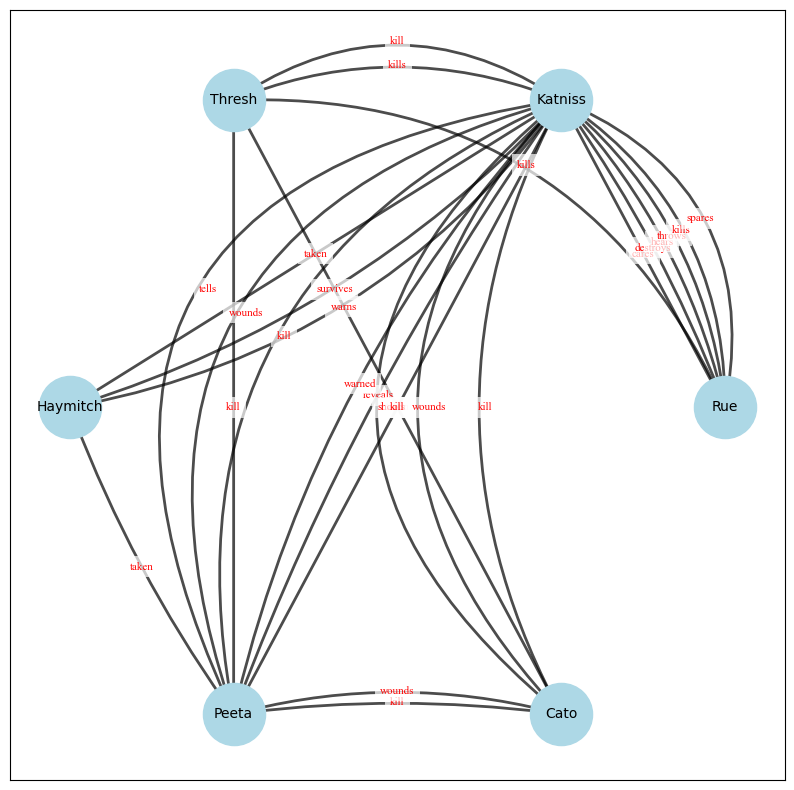

In [55]:
graph_plot(interactions_df)

This semantic character network, as well as the interactions list, the characters list, and the adjectives list are the results of our data processing pipeline as they summarize the character interactions and attributes captured by the movie plot.

By obtaining this character network for multiple movies, we may be able to compare them in order to detect patterns in movie structures, across genres, countries, and time

Keep in mind that the results of the functions we displayed are still a work in progress, as there is still room to significantly increase their accuracy.

## 3. Persona Extraction and Mapping
[Back to table of contents](#table-of-contents)

Our goal for persona extraction is to obtain the persona and the corresponding distributions of topics associated with each character. To do this, we plan to run the entire pipeline of [this repository](https://github.com/dbamman/ACL2013_Personas/tree/master). 
We are aware it's heavy computationally, we plan to make it by next week.

## 4. Main and Side Character Analysis
[Back to table of contents](#table-of-contents)

**Extraction of character adjectives**

To find adjectives, we use the Spacy library and perform text processing on the syntactic structure provided by the dependency tree to find words that are labeled as amod (adjectival modifier), acomp (adjectival complement) or others that are connected to the character.

**Identification of main and side characters**

To define main and side characters we could look at two things:
1. Frequency of the characters
2. Node-Related Measures such as degree, PageRank, Betweennesscentrality.

## 5. Network Dynamics Analysis
[Back to table of contents](#table-of-contents)

We define our character network as $G = (V, E)$, where the vertices represent the characters in the plot and the edges represent the interaction between the two characters. After constructing this network, we map each character to specific personas, as depicted in the diagram below.

![Persona mapping.png](./generated/images/persona_mapping.png)

After we get the persona network for each film, we "rebuild" the plot through these networks. Our objective is to compare the similarity (or difference) between these networks, focusing on two aspects: node and edge overlaps. We will use the Jaccard index [[1]](https://en.wikipedia.org/wiki/Jaccard_index) to compute the node set similarity and the edge set similarity.
$$J(A,B) = {{|A \cap B|}\over{|A \cup B|}} = {{|A \cap B|}\over{|A| + |B| - |A \cap B|}}$$